#  **Project: Capstone Project 2– v2**

**Project name:** - Citi Bike– Repricing case study and Twitter Sentiment analysis for real time reputation management

**Student Name:** - Jitendra Agarwal

**Course:** - Springboard cohort Jan2 2018

**Summary:** - 	Citi Bike is the largest bike share program in us, with 10,000 bikes and 600 stations across 
Manhattan, Brooklyn, Queens and Jersey City. It was designed for quick trips with convenience in mind, and it’s a fun and affordable way to get around town. Everyone knows that bike sharing is the answer to many environmental and urban transportation issues, yet it’s not mainstream in US. 
I am being asked by the senior executive team at Citi bike to use data science techniques to recommend 3 key action item to increase the company’s’ business. 

**Problem Statement: - **
    • Citi bike management is curious to know if there is any statistical way to find the reason in decline in trips observed few times last quarter. 
    • How are user sentiments about a recent change in pricing and if Citi bike is really useful for users from time, cost and efficiency point of view compared to other transportation options? 
    • How is the performance of unit economics per trip or per bike or per station? o What is the most common use of Citi bike? 
    • What measure can be taken to increase user trips by 5% with existing users. 

**Project Goals: ** -
    • User Sentiment analysis from twitter and identify most common customer issues and how to address them. 
    • Analyze if any of the current plan can be repriced to get 5% increase on revenue with no customer impact. 
    • Can we predict a right number of bike to stationed as a station? o Propose a new monthly pass pricing for office commuters.

# ** Pre Processing and Data Wrangling

In [1]:
#Import Pandas and read csv into a DataFrame

import pandas as pd

def filter_csv_to_df(filename, filters, chunk):
    
    df_new=pd.DataFrame()

    if chunk <= 10000 or chunk >= 100000000:
        chunk = 10 ** 8
        
    for data in pd.read_csv(filename, chunksize=chunk, low_memory=False):
        df = pd.DataFrame(data)
        df_new = pd.concat([df_new, df], axis=0)
        
        if filters == 'N':
            filter_df = df_new.loc[df_new['usertype'] != 'Subscriber']
        else:
            filter_df = df_new.loc[df_new['usertype'] == 'Subscriber']
            
    return filter_df


In [2]:
import numpy as np
from numpy import math 
from math import sin, cos, sqrt, atan2

def mile_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    km = 6371 * c
    miles = km * 0.621371 * 1.414
    if miles > 1.0 :
        score = 0
    else :
        score = 1
    return score

In [3]:
# Get Weather Data and  Cleanup to get daily minimum and average temperature for each day of Q4.
# Get summary data provided by Citibike on no of subscriber and daily pass purchases.

df_LMT = pd.DataFrame(pd.read_csv('../data/LMT_Q42017.csv'))
df_AVGT = pd.DataFrame(pd.read_csv('../data/AVGT_Q42017.csv'))
df_summ = pd.DataFrame(pd.read_csv('../data/2017Q4-summary.csv'))

df1 = pd.DataFrame()
df1 = pd.concat([df1, df_LMT['Oct'], df_LMT['Nov'], df_LMT['Dec']], axis=0)
df1 = df1.rename(index=str, columns={0: 'LMT'})

df2 = pd.DataFrame()
df2 = pd.concat([df2, df_AVGT['Oct'], df_AVGT['Nov'], df_AVGT['Dec']], axis=0)
df2 = df2.rename(index=str, columns={0: 'AVGT'})

df= pd.concat([df1, df2], axis=1)
df.insert(0, 'id', range(1, 1 + len(df)))
df_temp = df.query('id != 62')
df_temp['startdate'] = pd.to_datetime(np.arange(92), unit='D', origin=pd.Timestamp('2017-10-01'))
df_temp.reset_index(inplace=True)
df_temp.set_index('startdate')

df_temp['LMT'] = df_temp['LMT'].astype(int)
df_temp['AVGT'] = df_temp['AVGT'].astype(float)

print(df_temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 5 columns):
index        92 non-null object
id           92 non-null int64
LMT          92 non-null int64
AVGT         92 non-null float64
startdate    92 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.7+ KB
None


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set()

file_list = ['../data/201710-citibike-tripdata.csv', '../data/201711-citibike-tripdata.csv', '../data/201712-citibike-tripdata.csv']

df_sub = pd.DataFrame()
df_cust = pd.DataFrame()

for file in file_list:
        data_sub = filter_csv_to_df(file, 'Y', 100000000)
        
        df_sub = pd.concat([df_sub, data_sub], axis=0)
        
        data_cust = filter_csv_to_df(file, 'N', 100000000)

        df_cust = pd.concat([df_cust, data_cust], axis=0)

        

In [5]:
print (df_sub.shape)
print (df_cust.shape)

(3789518, 15)
(328690, 15)


In [6]:
# Seperate DATES and TIME in standard format
# Convert birth year to int, calculate User age and drop User with age > 99 (outliers)

# Calculate Driver Age.
df_sub = df_sub.dropna(subset = ['birth year'])
df_cust = df_cust.dropna(subset = ['birth year'])

df_sub['birth year'] = df_sub['birth year'].astype(int)
df_cust['birth year'] = df_cust['birth year'].astype(int)

df_sub['driver_age'] = pd.to_datetime('today').year-df_sub['birth year']
df_cust['driver_age'] = pd.to_datetime('today').year-df_cust['birth year']


df_sub = df_sub.query("driver_age < 100 ")
df_cust = df_cust.query("driver_age < 100 ")

### Rename Few column for easy reference

df_sub = df_sub.rename(index=str, columns={"start station id": 'start_id', "start station name": "start_name"})
df_cust = df_cust.rename(index=str, columns={"start station id": "start_id", "start station name": "start_name"})

df_sub = df_sub.rename(index=str, columns={"end station id": "end_id", "end station name": "end_name"})
df_cust = df_cust.rename(index=str, columns={"end station id": "end_id", "end station name": "end_name"})

df_sub = df_sub.rename(index=str, columns={"start station latitude": "start_lat", "start station longitude": "start_lon"})
df_cust = df_cust.rename(index=str, columns={"start station latitude": "start_lat", "start station longitude": "start_lon"})

df_sub = df_sub.rename(index=str, columns={"end station latitude": "end_lat", "end station longitude": "end_lon"})
df_cust = df_cust.rename(index=str, columns={"end station latitude": "end_lat", "end station longitude": "end_lon"})

df_sub.insert(0, 'trip_id', range(1, 1 + len(df_sub)))
df_cust.insert(0, 'trip_id', range(1, 1 + len(df_cust)))


In [7]:
# Extract date and hour from Datetime column
# Create a unique trip id for each trip

df_sub['startdate'] = pd.to_datetime(df_sub['starttime']).dt.date
df_cust['startdate'] = pd.to_datetime(df_cust['starttime']).dt.date

df_sub['starthour'] = pd.to_datetime(df_sub['starttime']).dt.hour
df_cust['starthour'] = pd.to_datetime(df_cust['starttime']).dt.hour

df_sub['enddate'] = pd.to_datetime(df_sub['stoptime']).dt.date
df_cust['enddate'] = pd.to_datetime(df_cust['stoptime']).dt.date

df_sub['endhour'] = pd.to_datetime(df_sub['stoptime']).dt.hour
df_cust['endhour'] = pd.to_datetime(df_cust['stoptime']).dt.hour

df_sub['start_day'] = pd.to_datetime(df_sub['starttime']).dt.dayofweek
df_cust['start_day'] = pd.to_datetime(df_cust['starttime']).dt.dayofweek

df_sub['end_day'] = pd.to_datetime(df_sub['stoptime']).dt.dayofweek
df_cust['end_day'] = pd.to_datetime(df_cust['stoptime']).dt.dayofweek

In [8]:
# Create New columns to identify if Trip was free i.e covered in the pass or not
# what are paid units of each trip and $ paid based on plans

df_sub['free_trip'] = np.where(df_sub['tripduration'] <= 2700, 1, 0)
df_cust['free_trip'] = np.where(df_cust['tripduration'] <= 1800, 1, 0)

df_sub['paidunits'] = np.where(df_sub['free_trip'] == 0 ,np.ceil((df_sub['tripduration']-2700)/900), 0)
df_cust['paidunits'] = np.where(df_cust['free_trip'] == 0 ,np.ceil((df_cust['tripduration']-1800)/900), 0)

df_sub['paidamount'] = np.where(df_sub['paidunits'] > 0 ,df_sub['paidunits']*2.5, 0)
df_cust['paidamount'] = np.where(df_cust['paidunits'] > 0 ,df_cust['paidunits']*4.0, 0)

print (df_sub.tail(10))
print (df_sub.shape)

print (df_cust.tail(10))
print (df_cust.shape)

        trip_id  tripduration            starttime             stoptime  \
889957  3726257           411  2017-12-31 23:49:34  2017-12-31 23:56:25   
889958  3726258           433  2017-12-31 23:49:36  2017-12-31 23:56:50   
889959  3726259           606  2017-12-31 23:50:04  2018-01-01 00:00:11   
889960  3726260          1088  2017-12-31 23:50:08  2018-01-01 00:08:16   
889961  3726261           429  2017-12-31 23:52:25  2017-12-31 23:59:34   
889962  3726262           397  2017-12-31 23:54:22  2018-01-01 00:01:00   
889963  3726263           332  2017-12-31 23:54:44  2018-01-01 00:00:16   
889964  3726264           565  2017-12-31 23:56:07  2018-01-01 00:05:33   
889965  3726265          1659  2017-12-31 23:57:16  2018-01-01 00:24:56   
889966  3726266          1279  2017-12-31 23:58:56  2018-01-01 00:20:16   

        start_id            start_name  start_lat  start_lon  end_id  \
889957      3288       E 88 St & 1 Ave  40.778301 -73.948813    3292   
889958      3288       E 88 St

In [9]:
# Create a DF for unique list of station

df_station1 = df_sub[['start_id', 'start_name', 'start_lat', 'start_lon']]
df_station2 = df_sub[['end_id', 'end_name', 'end_lat', 'end_lon']]

df_station1['start_id'] = df_sub['start_id'].astype(int)
df_station2['end_id'] = df_sub['end_id'].astype(int)

df_station1.drop_duplicates()
df_station2.drop_duplicates()

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,end_id,end_name,end_lat,end_lon
0,478,11 Ave & W 41 St,40.760301,-73.998842
2,350,Clinton St & Grand St,40.715595,-73.987030
5,468,Broadway & W 56 St,40.765265,-73.981923
7,305,E 58 St & 3 Ave,40.760958,-73.967245
8,355,Bayard St & Baxter St,40.716021,-73.999744
9,295,Pike St & E Broadway,40.714067,-73.992939
10,3090,N 8 St & Driggs Ave,40.717746,-73.956001
12,458,11 Ave & W 27 St,40.751396,-74.005226
13,3346,Berkeley Pl & 7 Ave,40.675147,-73.975232
14,3314,W 95 St & Broadway,40.793770,-73.971888


In [10]:
# Create a Df for unique list of station
df_station1.append(df_station2)

df_stations = df_station1.rename(index=str, columns={"start_id": 'station_id', "start_name": "station_name", "start_lat": 'station_lat', "start_lon": "station_lon"})

df_stations.set_index(['station_id'], append=True)
df_stations = df_stations.sort_values(['station_id']).drop_duplicates(subset=['station_id'])

print(df_stations)

         station_id                         station_name  station_lat  \
26364            72                     W 52 St & 11 Ave    40.767272   
968399           79             Franklin St & W Broadway    40.719116   
39921            82               St James Pl & Pearl St    40.711174   
138400           83        Atlantic Ave & Fort Greene Pl    40.683826   
658986          116                      W 17 St & 8 Ave    40.741776   
124711          119             Park Ave & St Edwards St    40.696089   
186185          120          Lexington Ave & Classon Ave    40.686768   
698677          127                Barrow St & Hudson St    40.731724   
211319          128             MacDougal St & Prince St    40.727103   
138117          143            Clinton St & Joralemon St    40.692395   
886677          144                  Nassau St & Navy St    40.698399   
457698          146                 Hudson St & Reade St    40.716250   
1180476         150                    E 2 St & Ave

In [11]:
df = []
near_df = []
k = len(df_stations)
for i in range(0, k):
    near_count = 0
    for j in range(0, k):
        near =  mile_distance(df_stations.iloc[i]['station_lon'], df_stations.iloc[i]['station_lat'], df_stations.iloc[j]['station_lon'], df_stations.iloc[j]['station_lat'])
        near_count  = near_count + near;
        near_df.append(near_count)
    df.append({'near_count': near_count, 'origin': df_stations.iloc[i]['station_id']})    
    df_near = pd.DataFrame(df)

df_near.head()


,near_count,origin
0,27,72
1,38,79
2,40,82
3,45,83
4,45,116


In [12]:
#Calculate Unit Economics and create Monthly summary and calculate total monthyl revenue based on pricing

trip_bymonth = df_sub.groupby(pd.to_datetime(df_sub['startdate']).dt.month).agg({'tripduration': 'sum', 'bikeid':'nunique', 'trip_id':'count', 'paidunits':'sum' })
trip_bymonth = trip_bymonth.rename(index=str, columns={"tripduration": 'total_trip_time', "bikeid": "no_of_bikes", "trip_id": "no_of_trips"})

trip_bymonth_cust = df_cust.groupby(pd.to_datetime(df_cust['startdate']).dt.month).agg({'tripduration': 'sum', 'bikeid':'nunique', 'start_id':'count', 'paidunits':'sum' })
trip_bymonth_cust = trip_bymonth_cust.rename(index=str, columns={"tripduration": 'total_trip_time', "bikeid": "no_of_bikes", "start_id": "no_of_trips"})

trip_bymonth_summ = df_summ.groupby(pd.to_datetime(df_summ['Date']).dt.month).agg({'Trips': 'sum', 'Miles':'sum', 'Members':'max', '24-Hour-Passes':'sum', '3-Day-Passes':'sum' })

print('--------------------------------------------------------------------------')

avg_mile=7.456/60/60
print('As per Citi Bike, avg distance traveled per second in miles is=',avg_mile ) 
print('Total unique bikes used by subscribers in Q4=',len(df_sub['bikeid'].unique() )) 
print('Total No of Trips by subscribers in Q4=',len(df_sub['bikeid']) )
print('Each Subscriber pays per month=', 14.95)
print('--------------------------------------------------------------------------')

#caclulate total mile traveled, average mile per bike, avg time per bike, average mile per trip, average time per trip
trip_bymonth['month'] = ['OCT', 'NOV', 'DEC']
trip_bymonth['total_distance'] = np.around(trip_bymonth['total_trip_time']*avg_mile, decimals=2)

trip_bymonth['avg_dis_per_trip'] = np.around(trip_bymonth['total_distance']/trip_bymonth['no_of_trips'], decimals=2)
trip_bymonth['avg_time_per_trip'] = np.around((trip_bymonth['total_trip_time']/trip_bymonth['no_of_trips'])/60, decimals=2)

trip_bymonth['avg_trip_per_bike'] = np.around(trip_bymonth['no_of_trips']/trip_bymonth['no_of_bikes'], decimals=2)
trip_bymonth['avg_dis_per_bike'] = np.around(trip_bymonth['total_distance']/trip_bymonth['no_of_bikes'], decimals=2)
trip_bymonth['avg_time_per_bike'] = np.around((trip_bymonth['total_trip_time']/trip_bymonth['no_of_bikes'])/60, decimals=2)

trip_bymonth_summ['pass_revenue_bysubs'] = np.around(trip_bymonth_summ['Members']*14.95, decimals=2)
trip_bymonth_summ['pass_revenue_bycust_1d'] = np.around(trip_bymonth_summ['24-Hour-Passes']*12, decimals=2)
trip_bymonth_summ['pass_revenue_bycust_3d'] = np.around(trip_bymonth_summ['3-Day-Passes']*24, decimals=2)

trip_bymonth['paid_trip_revenue_bysubs'] = np.around(trip_bymonth['paidunits']*2.5, decimals=2)
trip_bymonth_cust['paid_trip_revenue_bycust'] = np.around(trip_bymonth_cust['paidunits']*4, decimals=2)

trip_bymonth['paid_trip_monthly_revenue'] = trip_bymonth['paid_trip_revenue_bysubs']+trip_bymonth_cust['paid_trip_revenue_bycust']
trip_bymonth['paid_trip_revenue_bycust'] = trip_bymonth['paid_trip_monthly_revenue']-trip_bymonth['paid_trip_revenue_bysubs']

trip_bymonth_summ['All_pass_monthly_revenue'] = trip_bymonth_summ['pass_revenue_bysubs'] + trip_bymonth_summ['pass_revenue_bycust_1d'] + trip_bymonth_summ['pass_revenue_bycust_3d']

trip_bymonth['avg_reven_per_bike'] = np.around(5024220/trip_bymonth['no_of_bikes'], decimals=2)
trip_bymonth['avg_reven_per_trip'] = np.around(5024220/trip_bymonth['no_of_trips'], decimals=2)

print(trip_bymonth)
print('--------------------------------------------------------------------------')
print(trip_bymonth_summ)
print('--------------------------------------------------------------------------')

print("Total Q4 Revenue = " ,np.around(trip_bymonth_summ['All_pass_monthly_revenue'].sum() + trip_bymonth['paid_trip_monthly_revenue'].sum()))
print("Average monthly Revenue = " , np.around((trip_bymonth_summ['All_pass_monthly_revenue'].sum() + trip_bymonth['paid_trip_monthly_revenue'].sum())/3))


--------------------------------------------------------------------------
As per Citi Bike, avg distance traveled per second in miles is= 0.0020711111111111112
Total unique bikes used by subscribers in Q4= 13054
Total No of Trips by subscribers in Q4= 3726266
Each Subscriber pays per month= 14.95
--------------------------------------------------------------------------
           total_trip_time  no_of_bikes  no_of_trips  paidunits month  \
startdate                                                               
10              1355418246        11516      1663401   150177.0   OCT   
11               916593277        12773      1220354    85229.0   NOV   
12               602049732        11109       842511    57415.0   DEC   

           total_distance  avg_dis_per_trip  avg_time_per_trip  \
startdate                                                        
10             2807221.79              1.69              13.58   
11             1898366.52              1.56              12.52

In [13]:
# Few more cleanup and Descibe the dataframe.
df_sub['starthour'] = df_sub['starthour'].astype(int)
df_sub['endhour'] = df_sub['endhour'].astype(int)
df_sub['start_day'] = df_sub['start_day'].astype(int)

# Drop columns which are not needed to make df lighter 

df_sub.drop(['starttime', 'stoptime', 'start_name', 'end_name', 'birth year'], axis=1, inplace=True)
df_cust.drop(['starttime', 'stoptime', 'start_name', 'end_name', 'birth year'], axis=1, inplace=True)

print(df_sub.head())
df_sub.describe()

   trip_id  tripduration  start_id  start_lat  start_lon  end_id    end_lat  \
0        1           457       479  40.760193 -73.991255     478  40.760301   
2        2           761       504  40.732219 -73.981656     350  40.715595   
5        3           260      3443  40.761330 -73.979820     468  40.765265   
7        4           808      3305  40.781122 -73.949656     305  40.760958   
8        5          1143       284  40.739017 -74.002638     355  40.716021   

     end_lon  bikeid    usertype     ...      driver_age   startdate  \
0 -73.998842   30951  Subscriber     ...              33  2017-10-01   
2 -73.987030   28713  Subscriber     ...              26  2017-10-01   
5 -73.981923   27600  Subscriber     ...              28  2017-10-01   
7 -73.967245   17737  Subscriber     ...              25  2017-10-01   
8 -73.999744   20172  Subscriber     ...              26  2017-10-01   

  starthour     enddate endhour  start_day  end_day  free_trip  paidunits  \
0         0  20

,trip_id,tripduration,start_id,start_lat,start_lon,end_id,end_lat,end_lon,bikeid,gender,driver_age,starthour,endhour,start_day,end_day,free_trip,paidunits,paidamount
count,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06
mean,1.863134e+06,7.712979e+02,1.440701e+03,4.073716e+01,-7.398286e+01,1.428904e+03,4.073715e+01,-7.398373e+01,2.559676e+04,1.241310e+00,3.903543e+01,1.367407e+01,1.381377e+01,2.706733e+00,2.707514e+00,9.930877e-01,7.858296e-02,1.964574e-01
std,1.075680e+06,1.039112e+04,1.388033e+03,1.244255e-01,2.175515e-01,1.385444e+03,4.591808e-02,5.712936e-02,5.982522e+03,4.392722e-01,1.186143e+01,4.900341e+00,4.928896e+00,1.891782e+00,1.892211e+00,8.285230e-02,1.152036e+01,2.880089e+01
min,1.000000e+00,6.100000e+01,7.200000e+01,0.000000e+00,-7.403423e+01,7.200000e+01,0.000000e+00,-7.406692e+01,1.452900e+04,0.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.315672e+05,3.410000e+02,3.730000e+02,4.071912e+01,-7.399490e+01,3.680000e+02,4.071911e+01,-7.399530e+01,1.956700e+04,1.000000e+00,3.000000e+01,9.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.863134e+06,5.500000e+02,4.950000e+02,4.073902e+01,-7.398683e+01,4.920000e+02,4.073827e+01,-7.398700e+01,2.739700e+04,1.000000e+00,3.600000e+01,1.400000e+01,1.400000e+01,3.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,2.794700e+06,9.080000e+02,3.166000e+03,4.075641e+01,-7.397536e+01,3.164000e+03,4.075527e+01,-7.397575e+01,3.093300e+04,1.000000e+00,4.800000e+01,1.800000e+01,1.800000e+01,4.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,3.726266e+06,6.974419e+06,3.654000e+03,4.550585e+01,0.000000e+00,3.654000e+03,4.550636e+01,0.000000e+00,3.348100e+04,2.000000e+00,9.800000e+01,2.300000e+01,2.300000e+01,6.000000e+00,6.000000e+00,1.000000e+00,7.747000e+03,1.936750e+04


###### Calculated Average Monthly Revenue is  $5,024,220
###### --------------------------------------------------------------------------------------------------------------------

# Data Visualization and Exploratory Data Analysis:-

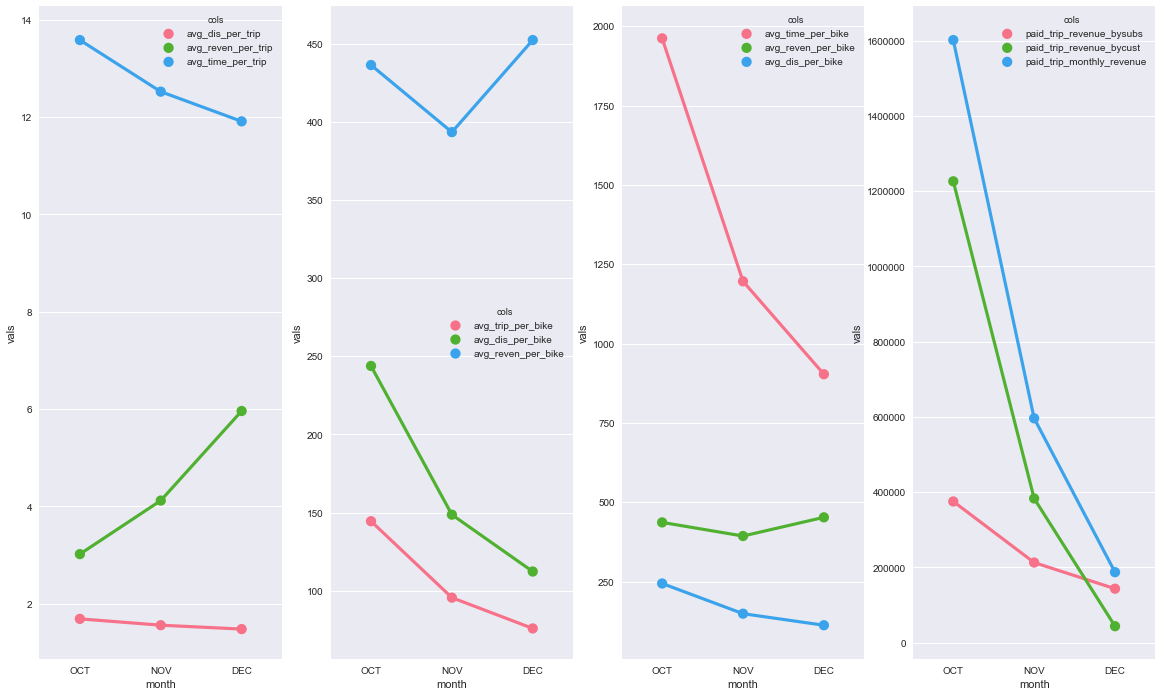

In [14]:
# Plot the Key unit metrics per trip and per bike for each month

df = trip_bymonth[['month','avg_dis_per_trip','avg_reven_per_trip','avg_time_per_trip']]
df1 = df.melt('month', var_name='cols',  value_name='vals')

df = trip_bymonth[['month','avg_trip_per_bike','avg_dis_per_bike','avg_reven_per_bike']]
df2 = df.melt('month', var_name='cols',  value_name='vals')

df = trip_bymonth[['month','avg_time_per_bike','avg_reven_per_bike','avg_dis_per_bike']]
df3 = df.melt('month', var_name='cols',  value_name='vals')

df = trip_bymonth[['month','paid_trip_revenue_bysubs','paid_trip_revenue_bycust','paid_trip_monthly_revenue']]
df4 = df.melt('month', var_name='cols',  value_name='vals')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,12))

ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=1)
ax4.legend(loc=1)

sns.factorplot(x="month", y="vals", hue='cols', data=df1, palette="husl", ax=ax1, legend = False)
sns.factorplot(x="month", y="vals", hue='cols', data=df2, palette="husl", ax=ax2, legend = False)
sns.factorplot(x="month", y="vals", hue='cols', data=df3, palette="husl", ax=ax3, legend = False)
sns.factorplot(x="month", y="vals", hue='cols', data=df4, palette="husl", ax=ax4, legend = False)

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)


###### **December month have seen less number of trips anfd hence the trip and distance per bike decreased but revenue per bike has increased.

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


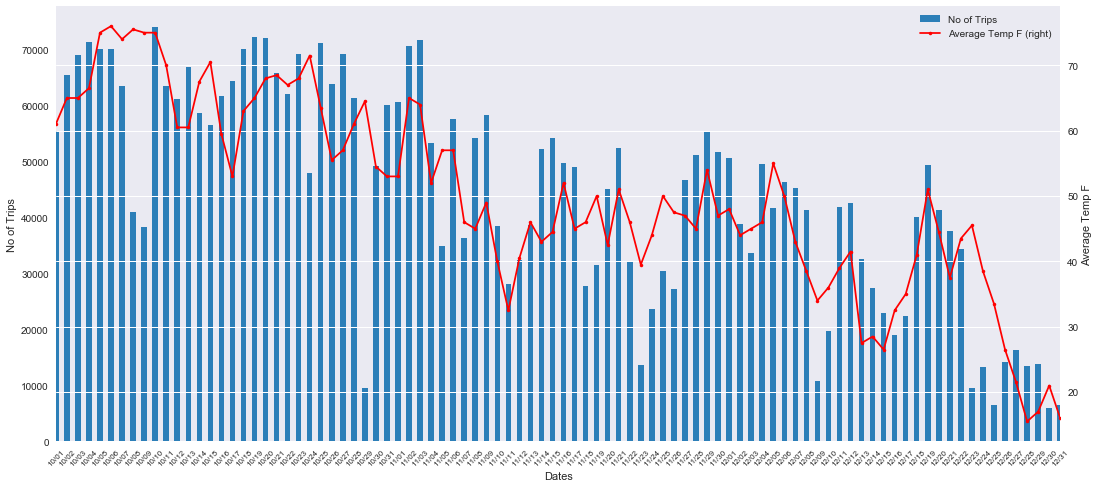

In [31]:
# How many trips happened each day of Q4 and plot it with the average temp for each day

newdf_c = df_sub.groupby(['startdate']).agg({'trip_id':{'counts': 'count'}})

ax1 = df_summ.Trips.plot(kind = 'bar', figsize=(18, 8), color='#2c7fb8', linewidth=.01, label="No of Trips", legend=True)
ax2 = df_temp.AVGT.plot(secondary_y=True, marker='.', label="Average Temp F", color='red', legend=True)

ax1.set_xticklabels(labels=pd.to_datetime(df_summ['Date']).dt.strftime('%m/%d'), fontdict={'fontsize':8}, rotation=45)
ax1.set_xlabel("Dates")
ax1.set_ylabel("No of Trips")
ax2.set_ylabel("Average Temp F")

plt.show()

###### ** Temperature is a big factor for people to take a bike trip. in the cold days the bike trips were dropped significantly.

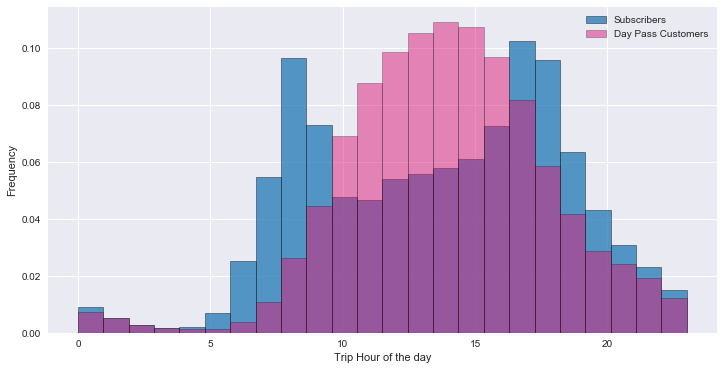

In [32]:
# Plot trip distribution by hour of the day in entire Q4 for subscriber

plt.figure(figsize=(12,6))
df_sub['starthour'].plot('hist', legend=True, normed=True, color='#2c7fb8', alpha = 0.8, label="Subscribers", edgecolor='black', linewidth=.5, bins=24)
df_cust['starthour'].plot('hist', legend=True, normed=True, color='#dd1c77', alpha = 0.5, label="Day Pass Customers", edgecolor='black', linewidth=.5, bins=24)
_ = plt.xlabel('Trip Hour of the day')
_ = plt.ylabel('Frequency')
plt.show()




###### ** Monthly subscribers take most trip during Rush Hours while Day pass holder are taking most trips between 11 AM-4 PM

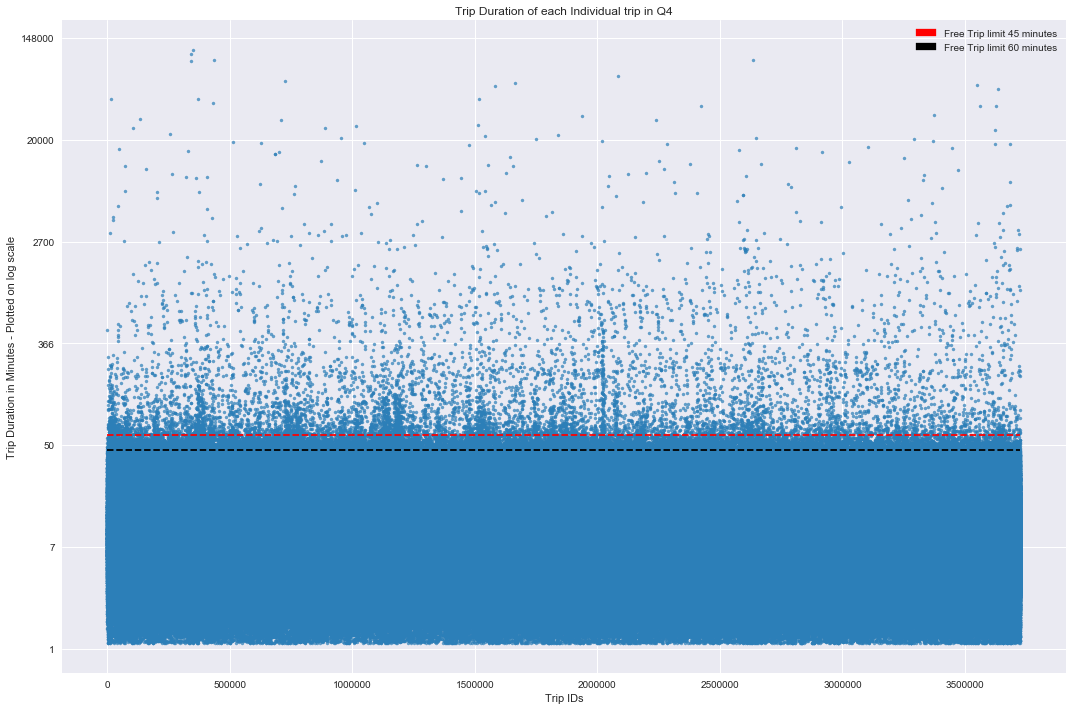

In [33]:
# Plot Trip Duration of each trip and show the threshold of free trip limit of 45 minutes for Subscribers
import matplotlib.patches as mpatches

# we need to create the log scale for trip duration to fit in uniform scale.
df_sub["logtripduration"] = np.log(df_sub["tripduration"])

df_sub.plot.scatter(x='trip_id', y='logtripduration', figsize=(18, 12), color='#2c7fb8', alpha=.7, linewidth=.2, label='Bike trips', s=10);

# draw two line to show the limit of free trip duration 45 minutes - log(45*60) and 60 minutes.
# log value of 2700 (45 minutes - free trip threshold) is 7.901 and log value of 3000 is 8.189

plt.plot([0, len(df_sub['trip_id'])], [7.90, 7.90], 'k--', color="Black")
plt.plot([0, len(df_sub['trip_id'])], [8.19, 8.19], 'k--', color="Red")
_ = plt.xlabel('Trip IDs')
_ = plt.ylabel('Trip Duration in Minutes - Plotted on log scale')
_ = plt.title('Trip Duration of each Individual trip in Q4')

tick_val = [4,6,8,10,12,14,16]
tick_lab = ['1','7','50','366','2700','20000','148000']
_ = plt.yticks(tick_val, tick_lab)

red_patch = mpatches.Patch(color='red', label='Free Trip limit 45 minutes')
blk_patch = mpatches.Patch(color='Black', label='Free Trip limit 60 minutes')

plt.legend(handles=[red_patch,blk_patch])

plt.show()


###### ** We have used log scale to tune th long tail of trip duration. Area under 45 minutes and 60 minutes limit is equally high density. there are many outliers of trips duration upto multiple Days.

Average No of trips originating per Station in Q4 by Subscribers 4827.0


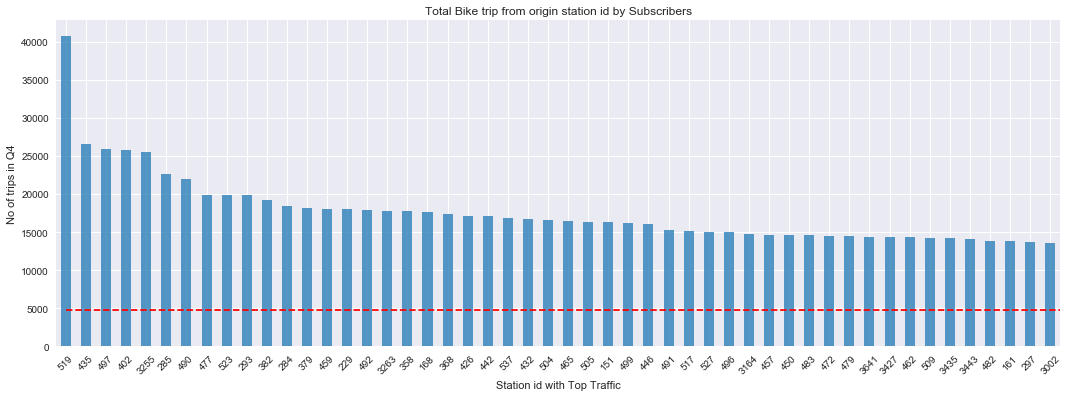

Average No of Paid trips originating per Station in Q4 by subscribers 34.0


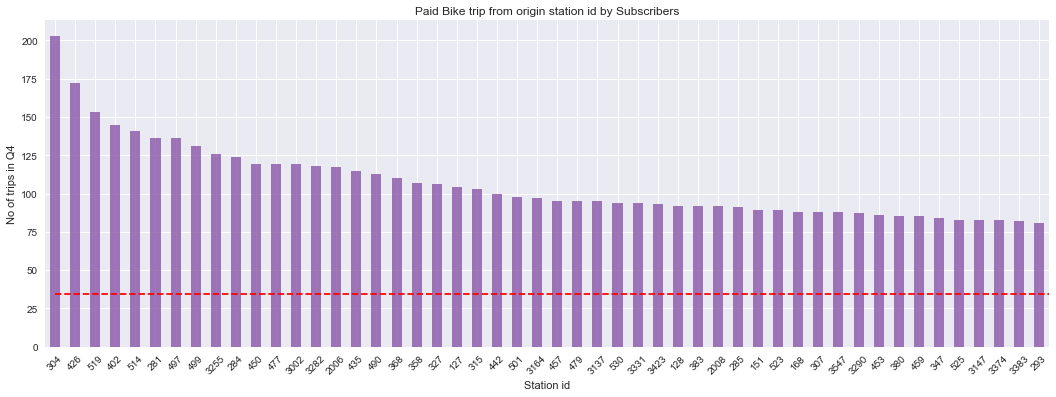

Average No of Paid trips originating per Station in Q4 by Customers 15.0


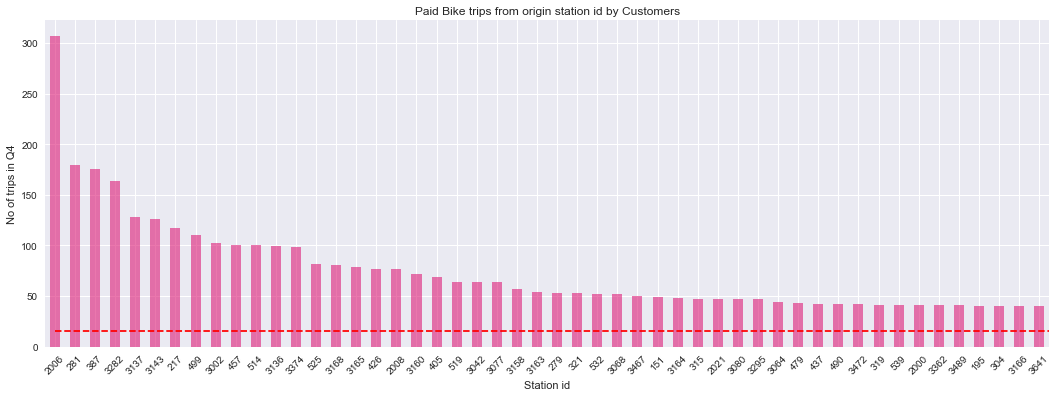

In [34]:
# Trip Origination Distribution by Station id: where are all trip starting from 

newdf1 = df_sub[['start_id']].groupby(df_sub['start_id']).count()
newdf1 = newdf1.rename(index=str, columns={"start_id": 'counts'})

av_trips_from_a_station = np.around(len(df_sub['trip_id'])/(len(newdf1['counts'])))
print("Average No of trips originating per Station in Q4 by Subscribers", av_trips_from_a_station)

#lets get top 30 Stattions based on no of trips

newdf = newdf1.nlargest(50, 'counts')

newdf.plot(kind='bar', figsize=(18, 6), label = '', legend=False, color='#2c7fb8', linewidth=.01, alpha=0.8)
plt.plot([0, len(newdf['counts'])], [av_trips_from_a_station, av_trips_from_a_station], 'k--', color="Red",)

plt.xlabel('Station id with Top Traffic')
plt.ylabel('No of trips in Q4')
_ = plt.xticks(rotation=45)
plt.title('Total Bike trip from origin station id by Subscribers')
plt.show()

#---------------------------------------------------------------------------------------------------#
# Trip Origination Distribution by Station id: Where are the long(paid) trips happening by subscriber
# Find the paid trips (> 45 minutes) and show in plot when and where they are starting from.

df_paidtrip = df_sub.query("tripduration > 2700")
newdf = df_paidtrip[['start_id']].groupby(df_paidtrip['start_id']).count()
newdf = newdf.rename(index=str, columns={"start_id": 'counts'})

newdf_p = newdf.nlargest(50, 'counts')

av_paidtrip_from_a_station_bysub = np.around(len(df_paidtrip['trip_id'])/(len(newdf['counts'])))
print("Average No of Paid trips originating per Station in Q4 by subscribers", av_paidtrip_from_a_station_bysub)

newdf_p.plot(kind='bar', figsize=(18, 6), label = '', legend=False, color='#8856a7', linewidth=.1, alpha=0.8)
plt.plot([0, len(newdf_p['counts'])], [av_paidtrip_from_a_station_bysub, av_paidtrip_from_a_station_bysub], 'k--', color="Red",)
_ = plt.xticks(rotation=45)

plt.xlabel('Station id')
plt.ylabel('No of trips in Q4')
plt.title('Paid Bike trip from origin station id by Subscribers')
plt.show()

#---------------------------------------------------------------------------------------------------#
# Trip Origination Distribution by Station id: Where are the long(paid) trips happening by Customers
# For 1-Day or 3-Day pass holders

df_custpaidtrip = df_cust.query("tripduration > 1800")

newdf = df_custpaidtrip[['start_id']].groupby(df_custpaidtrip['start_id']).count()
newdf = newdf.rename(index=str, columns={"start_id": 'counts'})

newdf_pc = newdf.nlargest(50, 'counts')

av_paidtrip_from_a_station_bycust = np.around(len(df_custpaidtrip['trip_id'])/(len(newdf['counts'])))
print("Average No of Paid trips originating per Station in Q4 by Customers", av_paidtrip_from_a_station_bycust)

newdf_pc.plot(kind='bar', figsize=(18, 6), label = '', legend=False, color='#dd1c77', linewidth=.1, alpha=0.6)
plt.plot([0, len(newdf_pc['counts'])], [av_paidtrip_from_a_station_bycust, av_paidtrip_from_a_station_bycust], 'k--', color="Red",)
_ = plt.xticks(rotation=45)

plt.xlabel('Station id')
plt.ylabel('No of trips in Q4')
plt.title('Paid Bike trips from origin station id by Customers')
plt.show()

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Average no of long trips by Day/Hour for subscriber  306.0


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Average no of long trips by Day/Hour for customer  128.0


Text(0.5,1,'Peak Hours for long/paid trip by Day pass customers')

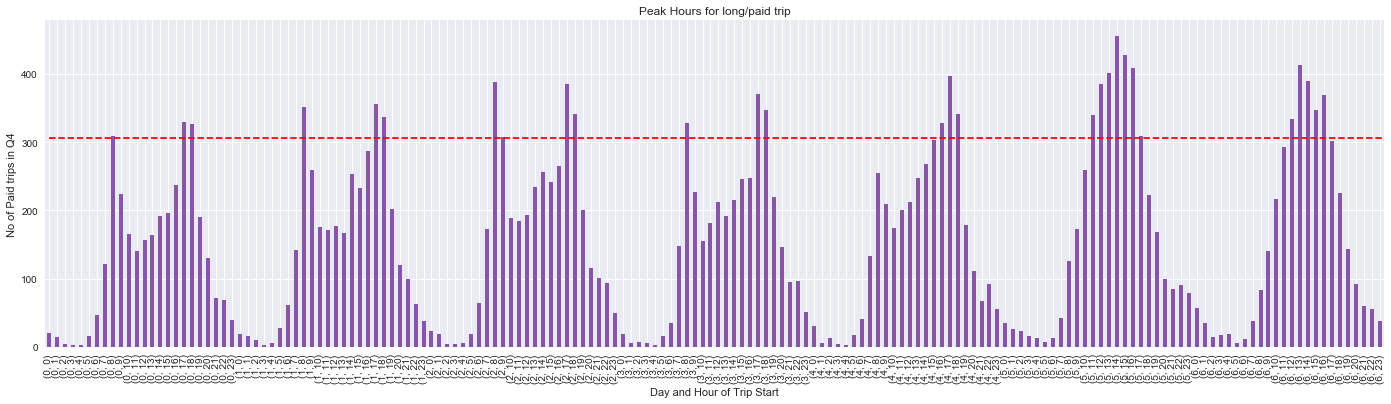

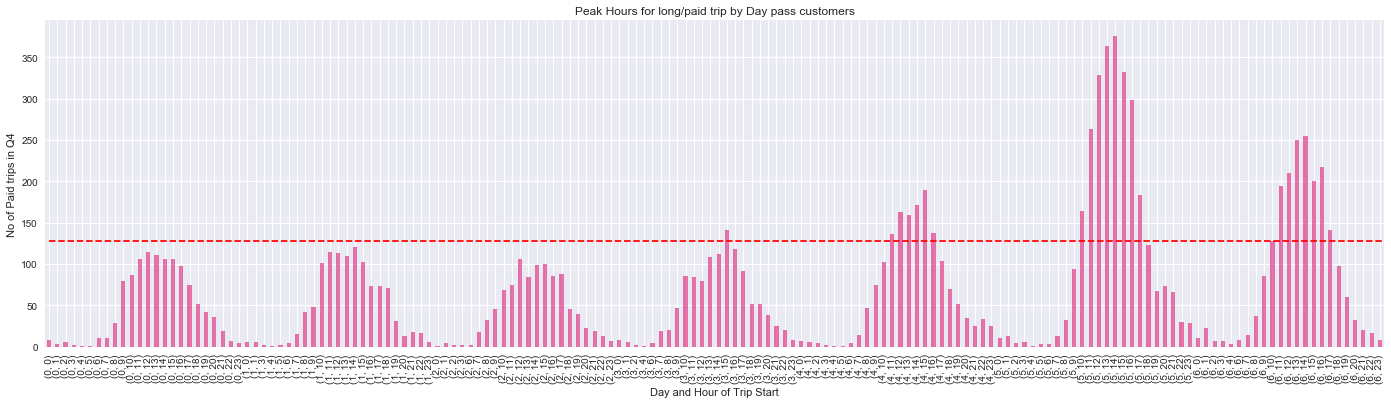

In [35]:
#Trip Distribution by Day/time of a week: When are the paid trips happening
df_paidtrip['paidunits'] = np.floor((df_paidtrip['tripduration']-2700)/900)

av_paid_trips_per_hour = np.around(len(df_paidtrip['paidunits'])/(24*7))
print("Average no of long trips by Day/Hour for subscriber ", 2*av_paid_trips_per_hour)

# Half od the day ( 8 PM to 8 AM) is non prime time to average multply by 2
df_agg_hour_day = pd.pivot_table(df_paidtrip, values='trip_id', index=([df_paidtrip['start_day'], df_paidtrip['starthour']]), aggfunc=np.count_nonzero)
df_agg_hour_day.plot(kind='bar', xticks=df_paidtrip.start_day, figsize=(24, 6), label = '', legend=False, color='#8856a7', linewidth=.08)
plt.plot([0, 168], [av_paid_trips_per_hour*2, av_paid_trips_per_hour*2], 'k--', color="Red",)

plt.xlabel('Day and Hour of Trip Start')
plt.ylabel('No of Paid trips in Q4')
plt.title('Peak Hours for long/paid trip')

#Trip Distribution by Day/time of a week: When are the paid trips happening by Day pass customers

df_custpaidtrip['paidunits'] = np.floor((df_custpaidtrip['tripduration']-1800)/900)

av_paid_trips_per_hour_cust = np.around(len(df_custpaidtrip['paidunits'])/(24*7))
print("Average no of long trips by Day/Hour for customer ", 2*av_paid_trips_per_hour_cust)

# Half of the day ( 8 PM to 8 AM) is non prime time to average multply by 2
df_agg_hour_day_cust = pd.pivot_table(df_custpaidtrip, values='trip_id', index=([df_custpaidtrip['start_day'], df_custpaidtrip['starthour']]), aggfunc=np.count_nonzero)
df_agg_hour_day_cust.plot(kind='bar', xticks=df_custpaidtrip.start_day, figsize=(24, 6), label = '', legend=False, color='#dd1c77', linewidth=.1, alpha=0.6)
plt.plot([0, 168], [av_paid_trips_per_hour_cust*2, av_paid_trips_per_hour_cust*2], 'k--', color="Red",)

plt.xlabel('Day and Hour of Trip Start')
plt.ylabel('No of Paid trips in Q4')
plt.title('Peak Hours for long/paid trip by Day pass customers')


###### ** Subscribers trips count is little more than average during Rush Hours in weekdays and afternoon in weekend. less Deviation.
###### ** For Day pass Holder trips count is less  than average during weekdays and mush high in afternoon in weekend. More Deviation.


average trips duration  by Subscribers 771.0


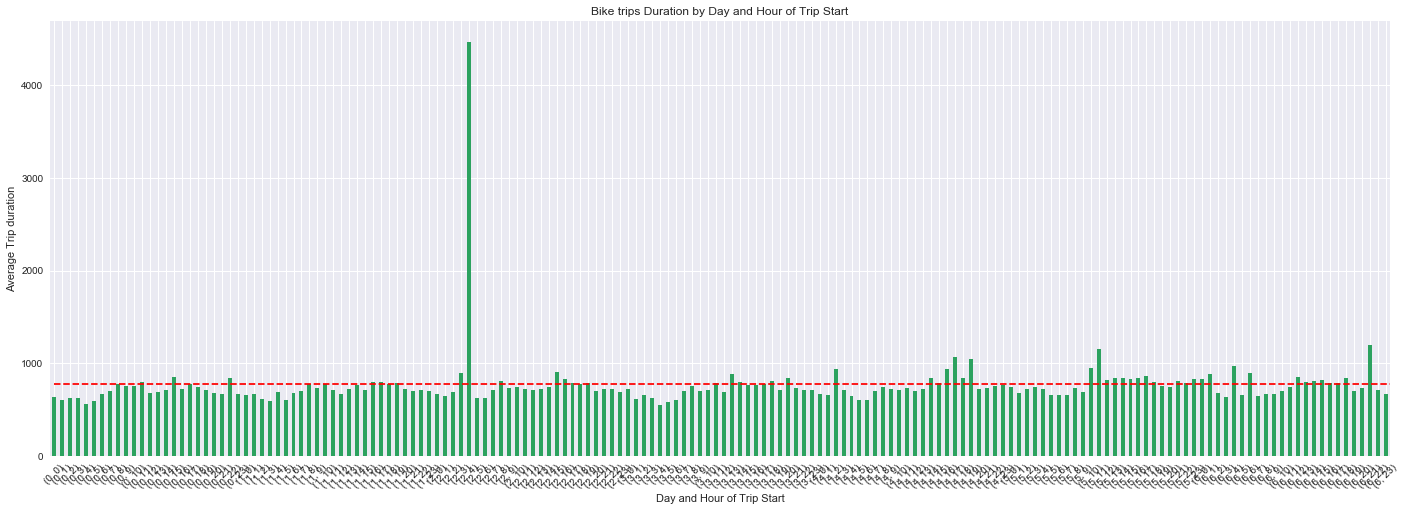

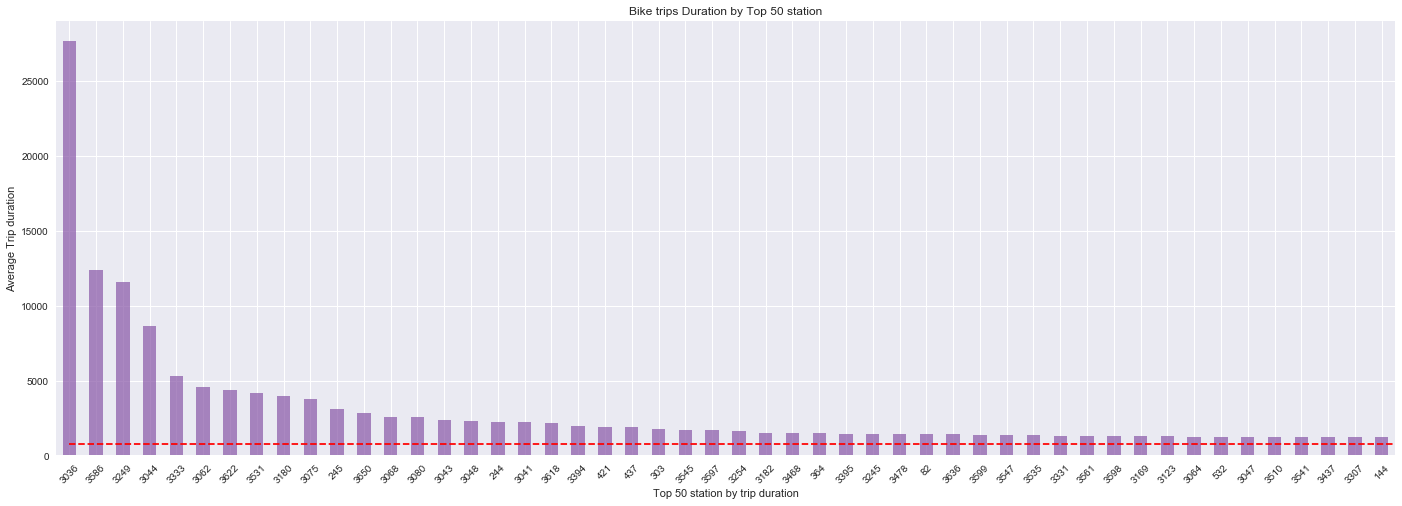

In [36]:
#Trip Duration over the Day/time of a week:

import numpy as np

av_trips_duration = np.around(np.sum(df_sub['tripduration'])/len(df_sub['trip_id']))
print("average trips duration  by Subscribers", av_trips_duration)

df_agg_hour_day = pd.pivot_table(df_sub, values='tripduration', index=([df_sub['start_day'], df_sub['starthour']]), aggfunc=np.mean)
df_agg_hour_day.plot(kind='bar', xticks=df_paidtrip.start_day, figsize=(24, 8), label = '', legend=False, color='#2ca25f', linewidth=.05)

plt.plot([0, 168], [av_trips_duration, av_trips_duration], 'k--', color="Red",)

plt.xlabel('Day and Hour of Trip Start')
plt.ylabel('Average Trip duration')
plt.title('Bike trips Duration by Day and Hour of Trip Start')
_ = plt.xticks(rotation=45)

plt.show()

#Trip Duration by the origination station:

df_agg_station = pd.pivot_table(df_sub, values='tripduration', index=([df_sub['start_id']]), aggfunc=np.mean)
df_agg_station = df_agg_station.rename(index=str, columns={"tripduration": 'meanduration'})

newdf_p = df_agg_station.nlargest(50, 'meanduration')

newdf_p.plot(kind='bar', xticks=df_paidtrip.start_day, figsize=(24, 8), label = '', legend=False, color='#8856a7', linewidth=.05, alpha=0.7)

plt.plot([0, 168], [av_trips_duration, av_trips_duration], 'k--', color="Red",)

plt.xlabel('Top 50 station by trip duration')
plt.ylabel('Average Trip duration')
plt.title('Bike trips Duration by Top 50 station')
_ = plt.xticks(rotation=45)

plt.show()


###### ** Hourly Average tirp duration by Subscriber is pretty much close to average except 1 outlier. Normal Distribution.
###### ** Hourly Average tirp duration by Subscriber is pretty high compared to avrage value from few stations.


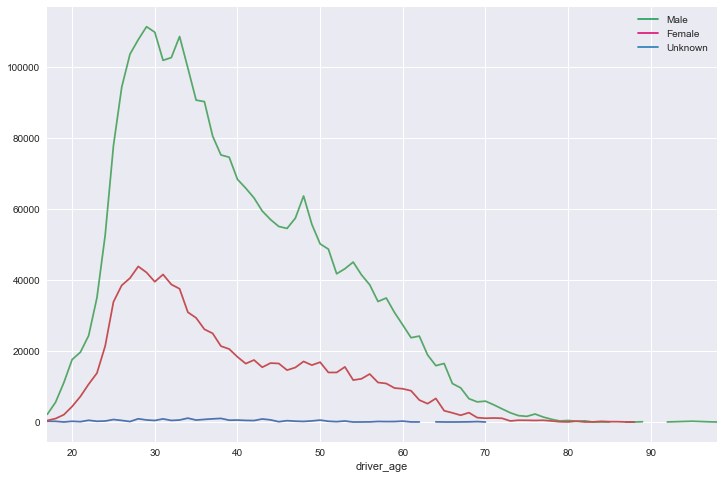

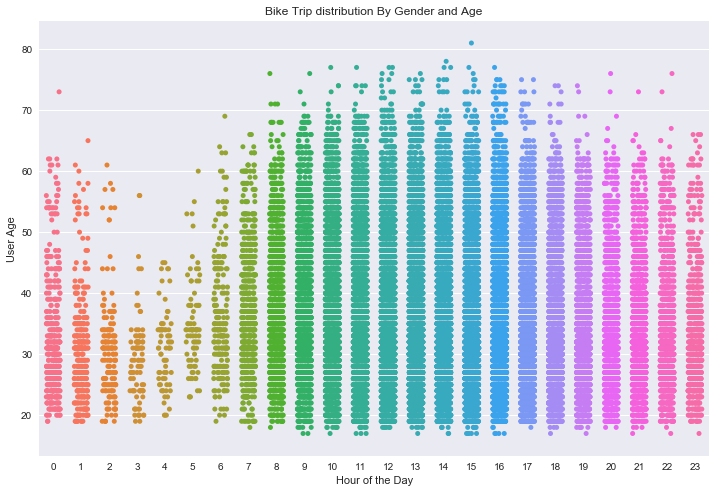

In [37]:
# Plot Bike Trip distribution By Gender and Age

df_agg_trips = pd.pivot_table(df_sub, values='bikeid', index=df_sub['driver_age'], columns=['gender'], aggfunc=np.count_nonzero)
df_agg_trips.plot(figsize=(12,8))

male, = plt.plot([1,2,3], color='#2ca25f', label='Male')
female, = plt.plot([3,2,1],  color='#dd1c77', label='Female')
othr, = plt.plot([3,2,1],  color='#3182bd', label='Unknown')
plt.legend([male, female, othr], ['Male', 'Female', 'Unknown'])

plt.figure(figsize=(12,8))
sns.stripplot(x="starthour", y="driver_age", data=df_cust, jitter=.25, palette="husl");
_ = plt.xlabel('Hour of the Day')
_ = plt.ylabel('User Age')
_ = plt.title('Bike Trip distribution By Gender and Age')


plt.show()

######  Male from 25-35 age is most common user segment for Subscribers. Younger users are taking trips during late night hours also.

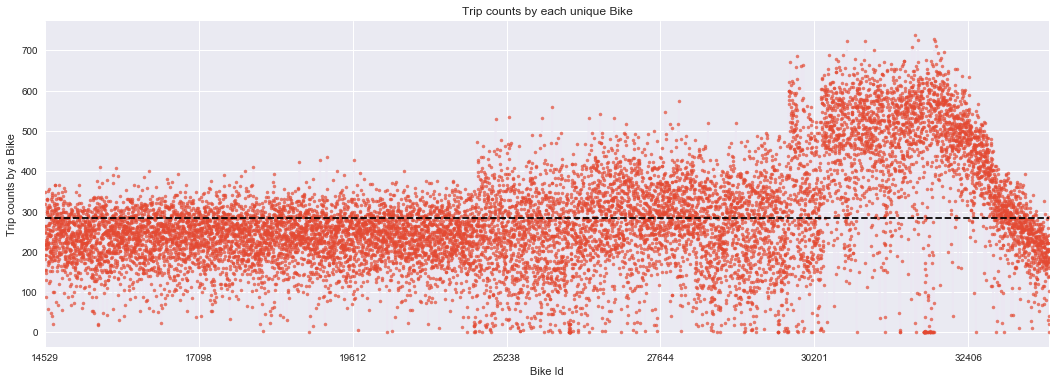

In [38]:
# Plot Trip counts by Bike Ids

newdf = df_sub[['bikeid']].groupby(df_sub['bikeid']).count()
#newdf1 = df_sub[['bikeid']].groupby(df_sub['tripduration']).sum()

newdf = newdf.rename(index=str, columns={"bikeid": 'counts'})

av_trips_per_bike = np.around(len(df_sub['trip_id'])/len(newdf['counts']))

newdf.plot(kind='line', figsize=(18, 6), label = '', marker='.', markerfacecolor='#e34a33', legend=False, color='#ece7f2',alpha=0.7)
plt.plot([0, len(newdf['counts'])], [av_trips_per_bike, av_trips_per_bike], 'k--', color="Black",)

_ = plt.xlabel('Bike Id')
_ = plt.ylabel('Trip counts by a Bike')
#_ = plt.xticks(rotation=45)
_ = plt.title('Trip counts by each unique Bike')

plt.show()


###### **  While most bikes are taking less trips then overall average, Some bikes are taking way more trips than average (almost double) . These may be due for major upgrades.

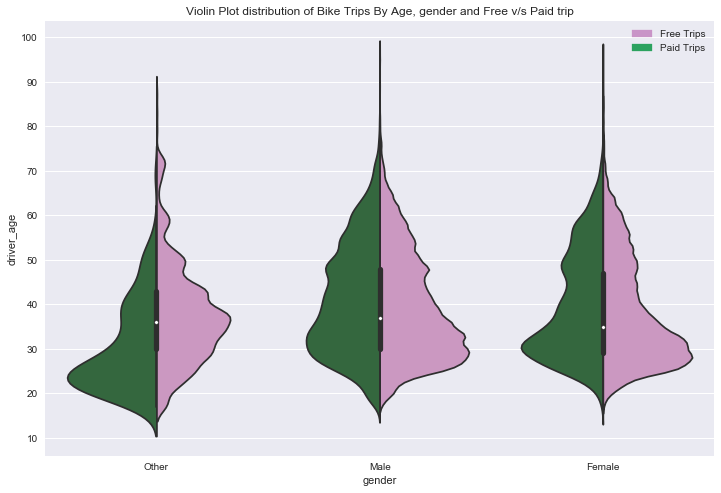

In [39]:
# Plot Bike Trip distribution By Gender, Age and paid v/s Free Trips

plt.figure(figsize=(12,8))
_ = plt.xlabel('Driver Gender')
_ = plt.ylabel('Driver Age')
_ = plt.title('Violin Plot distribution of Bike Trips By Age, gender and Free v/s Paid trip')
yint = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.yticks(yint)

ax = sns.violinplot(x="gender", y="driver_age", hue="free_trip", data=df_sub, split=True, palette="cubehelix", legend_out = False);
ax.set_xticklabels(['Other', 'Male', 'Female'])

free_patch = mpatches.Patch(color='#c994c7', label='Free Trips')
paid_patch = mpatches.Patch(color='#2ca25f', label='Paid Trips')

plt.legend(handles=[free_patch, paid_patch])

plt.show()

In [40]:
# Track and Plot Bike Movement In Peak Hours

df_hourly_bike_departs = df_sub.groupby(['start_id','startdate', 'starthour'], as_index=False).agg({'tripduration': 'sum', 'bikeid':'nunique', 'trip_id':'count', 'paidunits':'sum' })
df_hourly_bike_departs = df_hourly_bike_departs.rename(index=str, columns={"tripduration": 'total_trip_time_depart', "bikeid": "no_of_bikes_departs", "trip_id": "no_of_trips_depart"})

df_hourly_bike_arrive = df_sub.groupby(['end_id','enddate', 'endhour'], as_index=False).agg({'tripduration': 'sum', 'bikeid':'nunique', 'trip_id':'count', 'paidunits':'sum' })
df_hourly_bike_arrive = df_hourly_bike_arrive.rename(index=str, columns={"tripduration": 'total_trip_time_arrive', "bikeid": "no_of_bikes_arrive", "trip_id": "no_of_trips_arrive"})

df_hourly_bikes = []
df_hourly_bikes = pd.concat([df_hourly_bike_departs, df_hourly_bike_arrive], axis=1)
df_hourly_bikes['bike_moved'] = df_hourly_bikes['no_of_bikes_arrive'] - df_hourly_bikes['no_of_bikes_departs'] 

df_hourly_bikes.set_index(['startdate', 'starthour'], append=True)
pd.to_numeric(df_hourly_bikes['start_id'], errors='coerce')
df_hourly_bikes = df_hourly_bikes.dropna(subset = ['start_id'])
df_hourly_bikes['start_id'] = df_hourly_bikes['start_id'].astype(int)
df_hourly_bikes['starthour'] = df_hourly_bikes['starthour'].astype(int)

df_hourly_bikes = df_hourly_bikes[df_hourly_bikes['starthour'].isin(['7','8','9','16','17','18'])]

df_hourly_bikes.info()
print(df_hourly_bikes.head())

<class 'pandas.core.frame.DataFrame'>
Index: 284182 entries, 100 to 99994
Data columns (total 15 columns):
start_id                  284182 non-null int64
startdate                 284182 non-null object
starthour                 284182 non-null int64
total_trip_time_depart    284182 non-null float64
no_of_bikes_departs       284182 non-null float64
no_of_trips_depart        284182 non-null float64
paidunits                 284182 non-null float64
end_id                    284182 non-null int64
enddate                   284182 non-null object
endhour                   284182 non-null int64
total_trip_time_arrive    284182 non-null int64
no_of_bikes_arrive        284182 non-null int64
no_of_trips_arrive        284182 non-null int64
paidunits                 284182 non-null float64
bike_moved                284182 non-null float64
dtypes: float64(6), int64(7), object(2)
memory usage: 34.7+ MB
        start_id   startdate  starthour  total_trip_time_depart  \
100           72  2017-10-06 

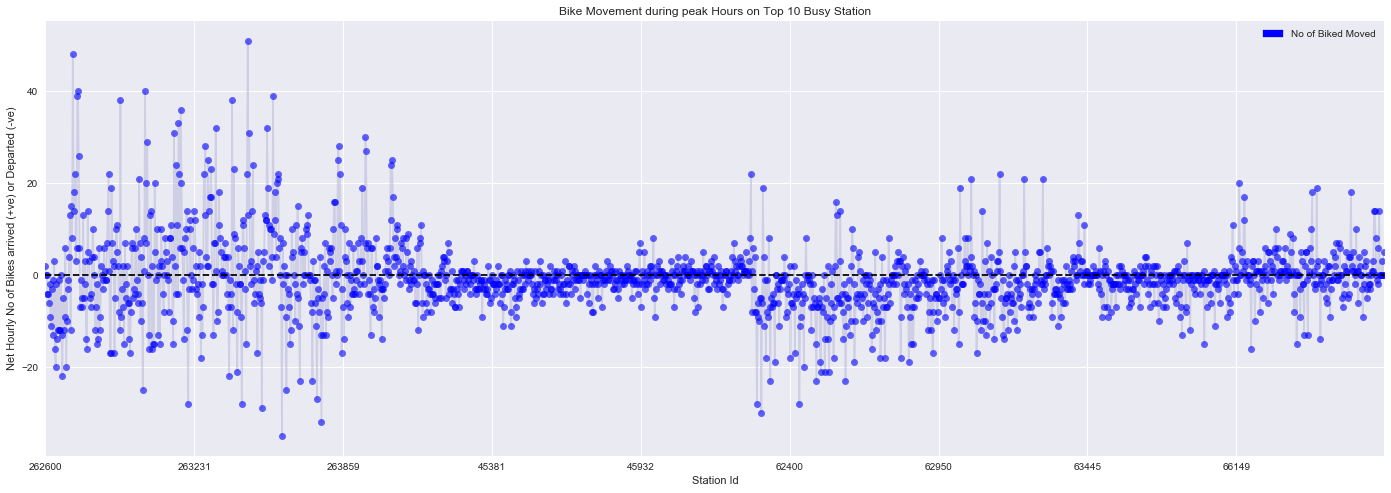

In [41]:
# Track and Plot Bike Movement In Peak Hours

newdf1 = df_sub[['start_id']].groupby(df_sub['start_id'], as_index=False).count()
newdf1 = newdf1.rename(index=str, columns={"start_id": 'counts'})

#lets get top 10 Stattions based on no of trips

newdf = newdf1.nlargest(10, 'counts')
newdf.reset_index(inplace=True)
newdf = newdf.rename(index=str, columns={"index": 'station_id'})

df = df_hourly_bikes[df_hourly_bikes['start_id'].isin(newdf['station_id'])]

plt.figure(figsize=(24,8))
df['bike_moved'].plot(color = '#bcbddc', marker = 'o', markerfacecolor = 'blue', alpha = 0.6)
plt.plot([0, len(df)], [0, 0], 'k--', color="Black",)

_ = plt.xlabel('Station Id')
_ = plt.ylabel('Net Hourly No of Bikes arrived (+ve) or Departed (-ve)')
_ = plt.title('Bike Movement during peak Hours on Top 10 Busy Station')
bikes = mpatches.Patch(color='blue', label='No of Biked Moved')

plt.legend(handles=[bikes])


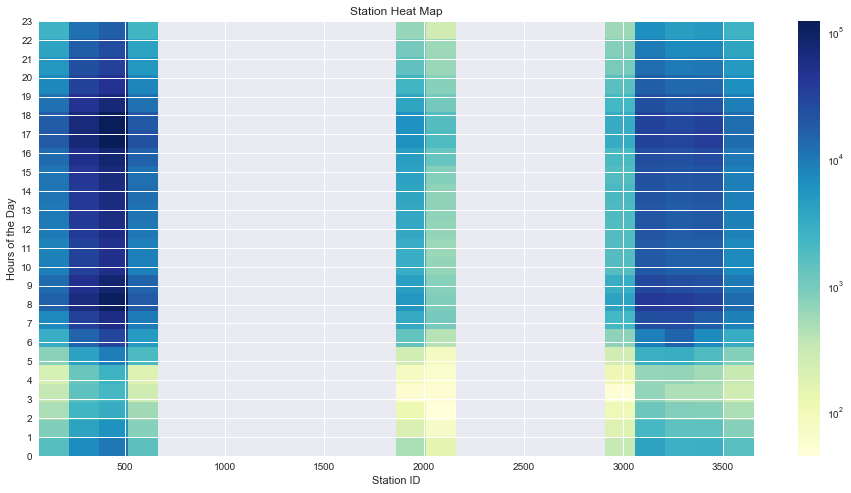

In [42]:
# Create a Heat map to show which station is busy againt the hour of the day.

from matplotlib.colors import LogNorm

plt.figure(figsize=(16,8))
plt.hist2d(x=df_sub.start_id, y=df_sub.starthour, bins=24, norm=LogNorm(), cmap = 'YlGnBu')
plt.title("Station Heat Map")
plt.xlabel("Station ID")
plt.ylabel("Hours of the Day")
tick_val = np.arange(24)
tick_lab = np.arange(24)
_ = plt.yticks(tick_val, tick_lab)
plt.xticks=df_sub[['start_id']]

plt.colorbar()
plt.show()


# Linear Regression Model:-

In [43]:
df_sub.describe()

,trip_id,tripduration,start_id,start_lat,start_lon,end_id,end_lat,end_lon,bikeid,gender,driver_age,starthour,endhour,start_day,end_day,free_trip,paidunits,paidamount,logtripduration
count,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06
mean,1.863134e+06,7.712979e+02,1.440701e+03,4.073716e+01,-7.398286e+01,1.428904e+03,4.073715e+01,-7.398373e+01,2.559676e+04,1.241310e+00,3.903543e+01,1.367407e+01,1.381377e+01,2.706733e+00,2.707514e+00,9.930877e-01,7.858296e-02,1.964574e-01,6.316965e+00
std,1.075680e+06,1.039112e+04,1.388033e+03,1.244255e-01,2.175515e-01,1.385444e+03,4.591808e-02,5.712936e-02,5.982522e+03,4.392722e-01,1.186143e+01,4.900341e+00,4.928896e+00,1.891782e+00,1.892211e+00,8.285230e-02,1.152036e+01,2.880089e+01,7.202056e-01
min,1.000000e+00,6.100000e+01,7.200000e+01,0.000000e+00,-7.403423e+01,7.200000e+01,0.000000e+00,-7.406692e+01,1.452900e+04,0.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.110874e+00
25%,9.315672e+05,3.410000e+02,3.730000e+02,4.071912e+01,-7.399490e+01,3.680000e+02,4.071911e+01,-7.399530e+01,1.956700e+04,1.000000e+00,3.000000e+01,9.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.831882e+00
50%,1.863134e+06,5.500000e+02,4.950000e+02,4.073902e+01,-7.398683e+01,4.920000e+02,4.073827e+01,-7.398700e+01,2.739700e+04,1.000000e+00,3.600000e+01,1.400000e+01,1.400000e+01,3.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.309918e+00
75%,2.794700e+06,9.080000e+02,3.166000e+03,4.075641e+01,-7.397536e+01,3.164000e+03,4.075527e+01,-7.397575e+01,3.093300e+04,1.000000e+00,4.800000e+01,1.800000e+01,1.800000e+01,4.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.811244e+00
max,3.726266e+06,6.974419e+06,3.654000e+03,4.550585e+01,0.000000e+00,3.654000e+03,4.550636e+01,0.000000e+00,3.348100e+04,2.000000e+00,9.800000e+01,2.300000e+01,2.300000e+01,6.000000e+00,6.000000e+00,1.000000e+00,7.747000e+03,1.936750e+04,1.575776e+01


In [44]:
#Create a new summary dataframe for oct, daily summary per station

#add customer and subs together then 
#station id, date:- day, no of trips, total trip duration, avg trip duration, density score, freetrip flag, paid trips units,

df_daily_trips = df_sub.groupby(['start_id','startdate'], as_index=False).agg({'tripduration': 'sum', 'bikeid':'nunique', 'trip_id':'count', 'paidunits':'sum', 'free_trip':'sum', 'start_day': 'max', 'driver_age':'median', 'paidamount':'sum' })
df_daily_trips = df_daily_trips.rename(index=str, columns={"tripduration": 'total_trip_time', "bikeid": "no_of_bikes", "trip_id": "no_of_trips", 'driver_age' :'median_user_age'})
df_daily_trips['startdate'] = pd.to_datetime(df_daily_trips['startdate'])

df_near = df_near.rename(index=str, columns={"origin": 'start_id'})

df_daily_trips = df_daily_trips.merge(df_near, how='left', on='start_id')
df_daily_trips = df_daily_trips.merge(df_temp[['startdate', 'AVGT']], how='left', on='startdate')

df_daily_trips = df_daily_trips.rename(index=str, columns={"near_count": 'density_score' })

df_daily_trips.head()

df_daily_trips.describe()

,start_id,total_trip_time,no_of_bikes,no_of_trips,paidunits,free_trip,start_day,median_user_age,paidamount,density_score,AVGT
count,65737.000000,6.573700e+04,65737.000000,65737.000000,65737.000000,65737.000000,65737.000000,65737.000000,65737.000000,65737.000000,65737.000000
mean,2201.004031,4.372060e+04,54.757488,56.684455,4.454432,56.292636,3.023640,36.868111,11.136080,32.279660,49.873283
std,1444.589433,9.273410e+04,64.367905,67.002394,87.035141,66.680753,2.007991,5.203279,217.587852,10.526593,14.524767
min,72.000000,6.300000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,17.500000,0.000000,1.000000,15.500000
25%,433.000000,8.475000e+03,12.000000,12.000000,0.000000,12.000000,1.000000,33.000000,0.000000,25.000000,41.500000
50%,3126.000000,2.294100e+04,31.000000,32.000000,0.000000,32.000000,3.000000,36.000000,0.000000,31.000000,48.000000
75%,3403.000000,5.746900e+04,73.000000,75.000000,1.000000,75.000000,5.000000,40.000000,2.500000,39.000000,61.000000
max,3654.000000,6.999414e+06,812.000000,896.000000,7751.000000,886.000000,6.000000,95.000000,19377.500000,58.000000,76.000000


In [16]:
# Creatting the Ordinary least squares (ols) model 
# ols model to predict total trip time from a station for a given day

import statsmodels.api as sm
from statsmodels.formula.api import ols

model1 = ols('total_trip_time ~ start_id + median_user_age + density_score + start_day + AVGT - 1', df_daily_trips).fit()
print(model1.summary())

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:        total_trip_time   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     4649.
Date:                Tue, 13 Feb 2018   Prob (F-statistic):               0.00
Time:                        01:30:23   Log-Likelihood:            -8.4179e+05
No. Observations:               65737   AIC:                         1.684e+06
Df Residuals:                   65732   BIC:                         1.684e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
start_id          -11.3849      0.250    -

In [45]:
#ols model to predict no of trips from a station for a given day

model2 = ols('no_of_trips ~ start_id + median_user_age + density_score + start_day + AVGT - 1', df_daily_trips).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            no_of_trips   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                 2.283e+04
Date:                Tue, 13 Feb 2018   Prob (F-statistic):               0.00
Time:                        09:58:32   Log-Likelihood:            -3.5434e+05
No. Observations:               65737   AIC:                         7.087e+05
Df Residuals:                   65732   BIC:                         7.087e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
start_id           -0.0148      0.000    -

The Squared R value of 2 model .635 v/s .262

The Akaike Information criteria (AIC) in this model2 is higher.  Lower values of AIC indicate better fitting models.

The probability for F-statistic in this model2 is also higher compared to model1. So we can say that this model1 is a better model.

co efficient varient valeu of the 5 paremter is significant and p valeu is zero. comparatively start_id has lesser value.

Density Score and AVGT has positive coefficient while start day and user age has negative coefficient

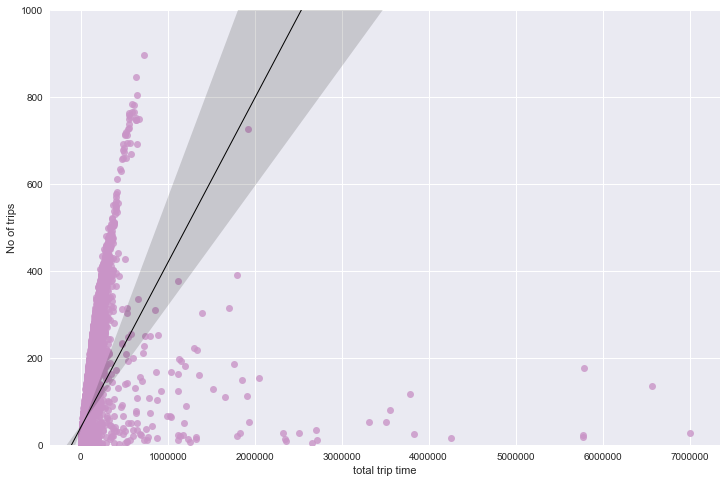

In [46]:
plt.figure(figsize=(12,8))
sns.regplot(y="no_of_trips", x="total_trip_time", data=df_daily_trips, fit_reg = True, color='#c994c7', line_kws={"linewidth": 1, "color": "black"})
plt.xlabel("total trip time")
plt.ylabel("No of trips")
_ = plt.ylim(0,1000)

plt.show()

**There is a liner relatonship between number of trips and total trip duration for a given day/station but there are many outliers displayed here.
If we can remove outlier and correctly tune the model for preciting no fo trips, we will be easily able to predict the total trip duration also from same model. **


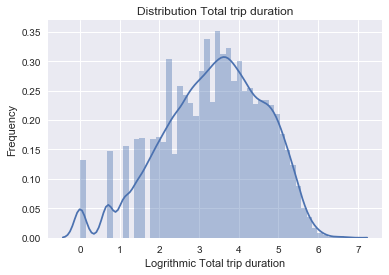

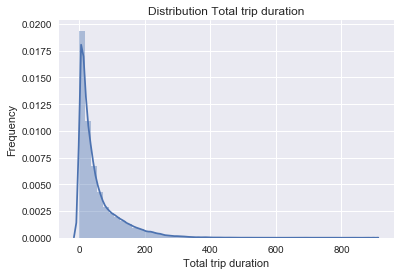

In [47]:
sns.distplot(np.log(df_daily_trips.no_of_trips));

plt.title("Distribution Total trip duration")
plt.xlabel("Logrithmic Total trip duration")
plt.ylabel("Frequency")
plt.show()

sns.distplot(df_daily_trips.no_of_trips);

plt.title("Distribution Total trip duration")
plt.xlabel("Total trip duration")
plt.ylabel("Frequency")
plt.show()

The distribution of trips is not normal without using the log. By using the log we can make the distribution modal normal distribution.

We can see that no of trips of crime is not evenly ditributed, without log function. one particular bin is way high in value and when we didnt use the log the high positive skew in the data couldn't be seen and rest are so relatively small that we cannot even notice them in chart. when we removed the log and plotted the histogram we can clearly see the skeweness in data distribution.

**To use linear regression, It is not Necessary for Y to be normally distributed.

Text(0,0.5,'tripduration log value')

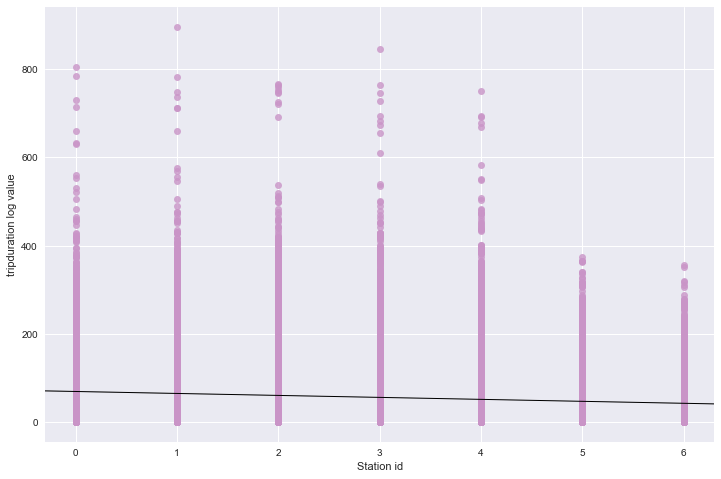

In [48]:
# Regression plot of Trip count againt Day of the week
plt.figure(figsize=(12,8))
sns.regplot(y="no_of_trips", x="start_day", data=df_daily_trips, fit_reg = True, color='#c994c7', line_kws={"linewidth": 1, "color": "black"})
plt.xlabel("Station id")
plt.ylabel("tripduration log value")

Text(0,0.5,'tripduration log value')

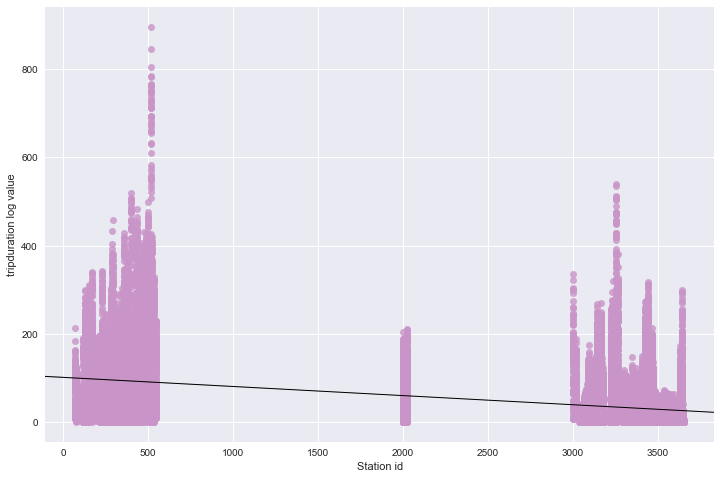

In [49]:
# Regression plot of Trip count againt Sttion id

plt.figure(figsize=(12,8))
sns.regplot(y="no_of_trips", x="start_id", data=df_daily_trips, fit_reg = True, color='#c994c7', line_kws={"linewidth": 1, "color": "black"})
plt.xlabel("Station id")
plt.ylabel("tripduration log value")

Text(0,0.5,'tripduration log value')

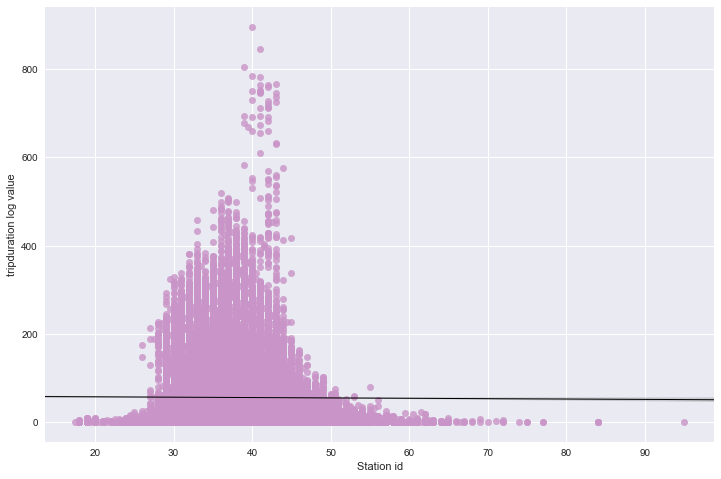

In [50]:
# Regression plot of Trip count againt median user Age

plt.figure(figsize=(12,8))
sns.regplot(y="no_of_trips", x="median_user_age", data=df_daily_trips, fit_reg = True, color='#c994c7', line_kws={"linewidth": 1, "color": "black"})
plt.xlabel("Station id")
plt.ylabel("tripduration log value")

Text(0,0.5,'tripduration log value')

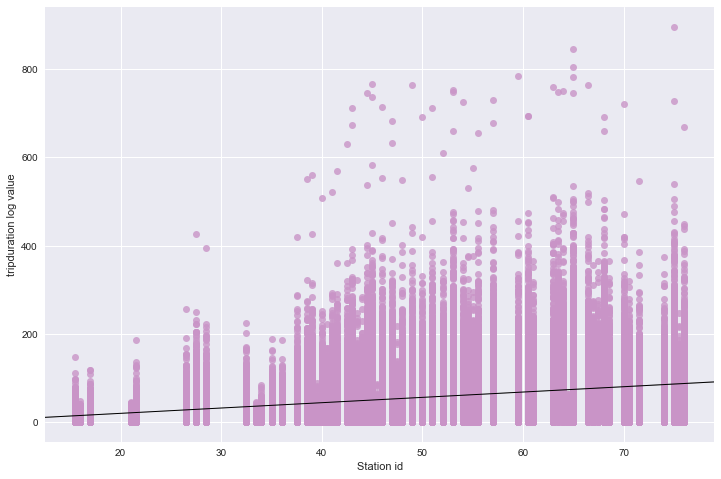

In [51]:
# Regression plot of Trip count againt Average temrature of the day

plt.figure(figsize=(12,8))
sns.regplot(y="no_of_trips", x="AVGT", data=df_daily_trips, fit_reg = True, color='#c994c7', line_kws={"linewidth": 1, "color": "black"})
plt.xlabel("Station id")
plt.ylabel("tripduration log value")

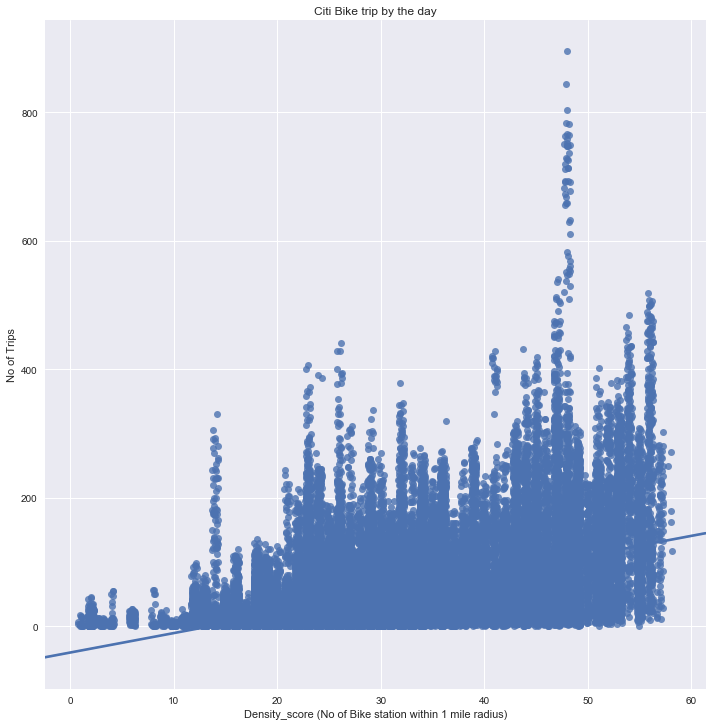

In [52]:
# Regression plot of Trip count againt Density Score

sns.lmplot(x="density_score", y="no_of_trips", data=df_daily_trips, x_jitter=.3, size=10, legend = False);
_ = plt.xlabel('Density_score (No of Bike station within 1 mile radius)')
_ = plt.ylabel('No of Trips')
_ = plt.title('Citi Bike trip by the day')

plt.show()

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# use newdf3 Dataframe from above because we want to use Driver age as that is teh only quantitavie feature.

df_daily_trips.drop(['startdate'], axis=1, inplace=True)

X = df_daily_trips.drop('no_of_trips', axis=1).values
y = df_daily_trips['no_of_trips'].values

Coefficients: 
 [  2.10729066e-05   2.46359956e-05   9.10787208e-02  -2.95648181e-03
   8.99921581e-01   2.89877666e-02  -2.45866503e-03  -7.39120454e-03
   1.01501704e-03   2.18952285e-03]
Mean squared error: 0.42
Variance score: 1.00
Estimated intercept coefficient: -0.12892798232261526
Number of coefficients: 10
predict score: [  14.99876448   18.17662744  188.91879381 ...,    8.07586326  108.76700156
  188.15435176]


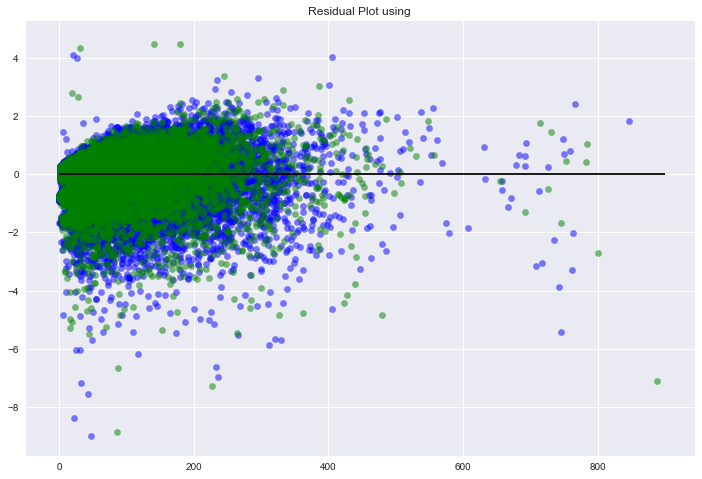

In [54]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# use newdf3 Dataframe from above because we want to use Driver age as that is teh only quantitavie feature.

X = df_daily_trips.drop('no_of_trips', axis=1).values
y = df_daily_trips['no_of_trips'].values

# Split the dataframe in test and train Dataframes 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_train, y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# The coefficients
print('Coefficients: \n', reg.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

print('Estimated intercept coefficient: {}'.format(reg.intercept_))

print('Number of coefficients: {}'.format(len(reg.coef_)))

print('predict score:', y_pred)


# Plot outputs
plt.figure(figsize=(12,8))

plt.scatter(reg.predict(X_train), reg.predict(X_train)-y_train, c='b', s=40, alpha = 0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test)-y_test, c='g', s=40, alpha = 0.5)
plt.hlines(y=0, xmin=0, xmax=900)
#plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.title("Residual Plot using ")
plt.show()


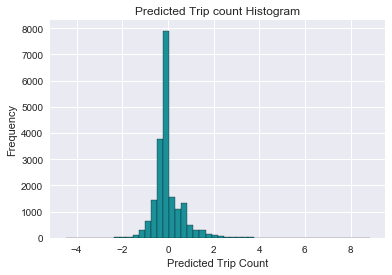

Stats of predicted Price:  DescribeResult(nobs=19722, minmax=(0.18100524409001295, 888.88594897362157), mean=56.998272722160003, variance=4616.997113439169, skewness=2.577864423904537, kurtosis=11.343832661874773)


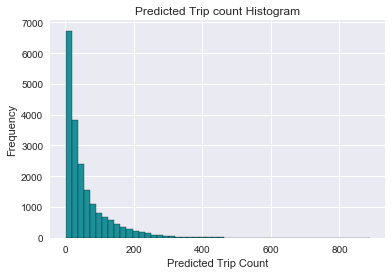

Stats of predicted Price:  DescribeResult(nobs=19722, minmax=(0.18100524409001295, 888.88594897362157), mean=56.998272722160003, variance=4616.997113439169, skewness=2.577864423904537, kurtosis=11.343832661874773)


In [55]:
# Plot a histogram of all the predicted prices
X_res = (y_test - reg.predict(X_test))

plt.hist(X_res, color='#1c9099', bins=50, edgecolor="k")
plt.title("Predicted Trip count Histogram")
plt.xlabel("Predicted Trip Count")
plt.ylabel("Frequency")
plt.show()

from scipy.stats import describe
print("Stats of predicted Price: ", describe(y_pred))


plt.hist(reg.predict(X_test), color='#1c9099', bins=50, edgecolor="k")
plt.title("Predicted Trip count Histogram")
plt.xlabel("Predicted Trip Count")
plt.ylabel("Frequency")
plt.show()

from scipy.stats import describe
print("Stats of predicted Price: ", describe(y_pred))

The histogram of residual values forms a bell curve. this indecates that the Residual are independently and identically distributed.

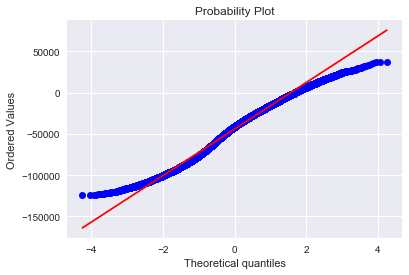

In [56]:
from scipy.stats import probplot, shapiro

qq = probplot(df_daily_trips.no_of_trips - model1.fittedvalues, plot=plt)

Quantile Plot is a graph of the residuals versus the expected order statistics of the standard normal distribution. This graph plots quantiles of the data versus quantiles.

The q-q plot shows that there is a positive skewness in the residual data also. The residual shouldnt have positive or negative skewness. This is another violation of the assumption in the linear model.

So it looks like the Residual plot is better.


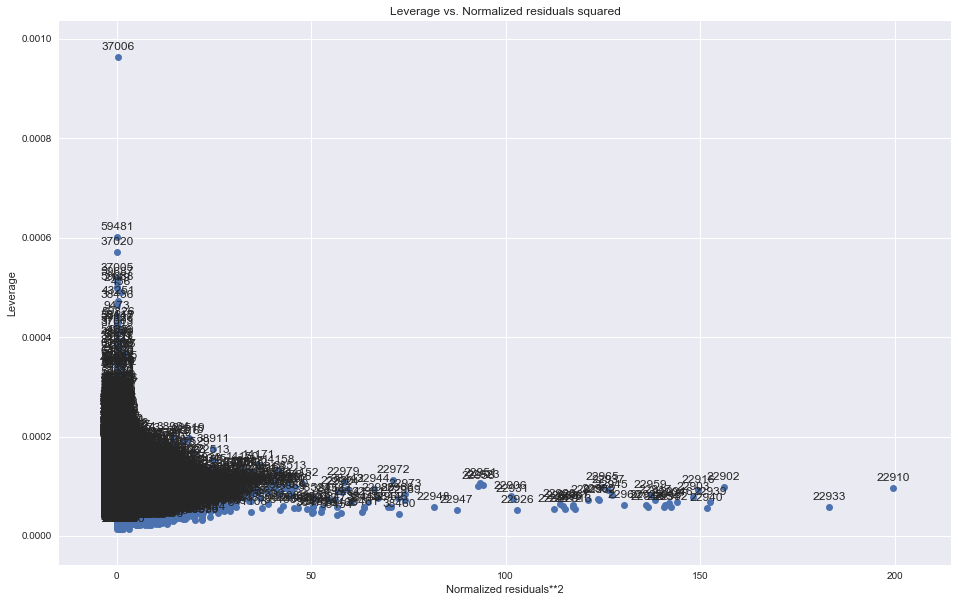

In [57]:
# Leverage Plot to see the level of deviations

from statsmodels.graphics.regressionplots import *

fig, ax = plt.subplots(figsize=(16,10))
fig = plot_leverage_resid2(model2, ax=ax, alpha=0.7)

Leverage: An observation with an extreme value on a predictor variable is called a point with high leverage. Leverage is a measure of how far an observation deviates from the mean of that variable. These leverage points can have an effect on the estimate of regression coefficients.

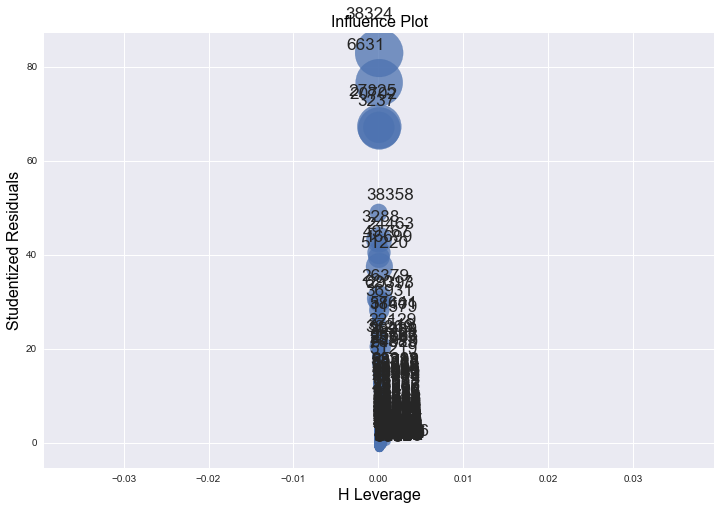

In [143]:
# Influence plot

fig, ax = plt.subplots(figsize=(12,8))
fig = influence_plot(model1, alpha  = 0.05, ax=ax)

In [18]:
%matplotlib inline

outl_index = [37006, 38324, 6631, 3237, 20702, 27825, 38358, 24463, 3288, 59481, 37020, 51220, 16699, 22910, 22933, 22902, 37005, 22916
             ]
hl_index = [38324, 6631, 3237, 27825, 38358, 20702]
out_hl_index = list(set(outl_index + hl_index))

cols = ["start_id", "median_user_age", "density_score" ,"start_day", "AVGT", "no_of_trips", "total_trip_time"]
df = df_daily_trips[cols]

outlier_df = df.iloc[outl_index]
hl_df = df.iloc[hl_index]
out_hl_df = df.iloc[out_hl_index]


# Outliers and high leverage putting together to check influence.

print(hl_df)
print(outlier_df)


       start_id  median_user_age  density_score  start_day  AVGT  no_of_trips  \
38324      3249             31.0             24          4  76.0           27   
6631        303             35.0             45          4  76.0          136   
3237        244             37.0             30          4  44.0           23   
27825      3062             33.0             23          6  75.5           17   
38358      3249             31.5             24          3  49.0           16   
20702       487             32.0             29          4  76.0          176   

       total_trip_time  
38324          6999414  
6631           6572756  
3237           5773421  
27825          5773033  
38358          4258918  
20702          5785061  
       start_id  median_user_age  density_score  start_day  AVGT  no_of_trips  \
37006      3180             95.0             25          5  21.0            1   
38324      3249             31.0             24          4  76.0           27   
6631        30

In [30]:
model3_df = df.drop(df.index[list(set(hl_index+outl_index))])
model3 = ols('no_of_trips ~ start_id + median_user_age + density_score + start_day + AVGT - 1', model3_df).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:            no_of_trips   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 2.300e+04
Date:                Tue, 13 Feb 2018   Prob (F-statistic):               0.00
Time:                        01:44:02   Log-Likelihood:            -3.5390e+05
No. Observations:               65719   AIC:                         7.078e+05
Df Residuals:                   65714   BIC:                         7.079e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
start_id           -0.0147      0.000    -

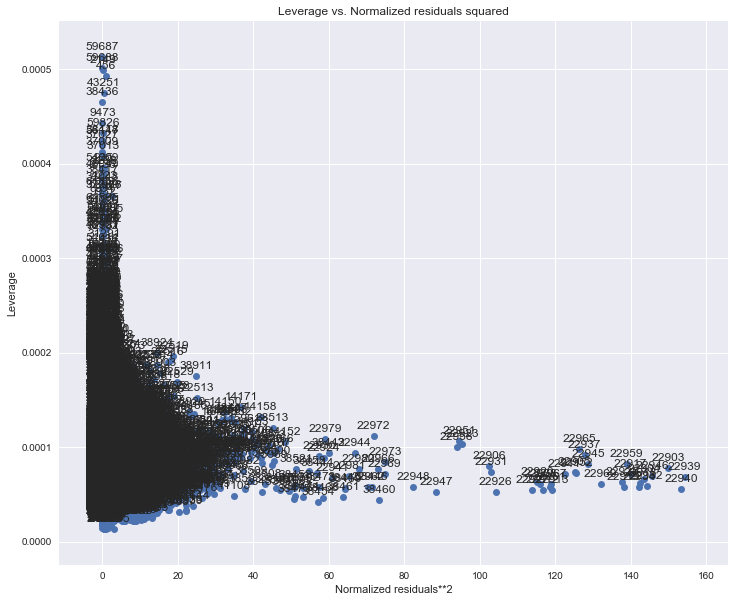

In [20]:
# Leverage Plot to see the level of deviations

from statsmodels.graphics.regressionplots import *

fig, ax = plt.subplots(figsize=(12,10))
fig = plot_leverage_resid2(model3, ax=ax, alpha=0.7)